In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import h5py
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
import os
import numpy as np
from wordcloud import WordCloud

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.debugging.set_log_device_placement(False)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
# simple way to load the complete dataset (for a more sophisticated generator example, see LLD-logo script)
# open hdf5 file
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
# load data into memory as numpy array
images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_64'][:])
real_logos = images

# Normalize pixel values to the range [0, 1]
real_logos = real_logos.astype('float32') / 255.0
# Split the data into training and validation sets
train_data, val_data = train_test_split(real_logos, test_size=0.2, random_state=42)

train_data_tenth = train_data[:int(len(train_data)/10)]


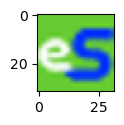

In [5]:
# Investigate the icon data using matplotlib
fig = plt.figure(figsize=(1, 1))
plt.imshow(np.transpose(images[20], (1, 2, 0)))

In [22]:
with tf.device('/gpu:0'):
    # Initiate a GAN model using tensorflow & keras
    # Generator
    latent_dim = 200
    generator = keras.Sequential()
    generator.add(layers.Dense(256, activation="relu", input_dim=latent_dim))
    generator.add(layers.Dense(512, activation="relu"))
    generator.add(layers.Dense(1024, activation="relu"))
    generator.add(layers.Dense(2048, activation="relu"))
    generator.add(layers.Dense(32*32*3, activation="relu"))
    generator.add(layers.Reshape((32, 32, 3)))

    # Discriminator
    discriminator = keras.Sequential()
    discriminator.add(layers.Flatten(input_shape=(32, 32,3)))
    discriminator.add(layers.Dense(1024, activation='relu'))
    discriminator.add(layers.Dense(512, activation='relu'))
    discriminator.add(layers.Dense(256, activation='relu'))
    discriminator.add(layers.Dense(1, activation='sigmoid'))

    # Discriminator Network
    discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002))

    # Create the GAN model
    discriminator.trainable = False
    gan = keras.Sequential([generator, discriminator])
    gan.compile(loss='binary_crossentropy', optimizer='adam')

In [25]:
def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

# Create a function to generate a batch of fake images
def generate_fake_samples(generator, n_samples, noise_dim):
    noise = generate_noise(n_samples, noise_dim)
    fake_logos = generator.predict(noise)
    return fake_logos

# Train the GAN model
def train_gan(generator, discriminator, gan, train_data, n_epochs, n_batches, batch_size, latent_dim):
    for epoch in range(n_epochs):
        for batch in range(n_batches):
            start_index = batch * batch_size
            end_index = min((batch + 1) * batch_size, train_data.shape[0])
            batch_indices = np.arange(start_index, end_index)
            real_batch = train_data[batch_indices]
            real_batch = np.transpose(real_batch, (0, 2, 3, 1))

            noise = generate_noise(real_batch.shape[0], latent_dim)
            fake_batch = generator.predict(noise)
            
            ## Discriminator Training Step
            # Adjust the label smoothing values
            real_label_smooth = 0.9 
            fake_label_smooth = 0.1 

            # Discriminator Training Step with Label Smoothing
            real_labels = np.ones((real_batch.shape[0], 1)) * real_label_smooth
            fake_labels = np.zeros((fake_batch.shape[0], 1)) + fake_label_smooth
            y = np.concatenate([real_labels, fake_labels])

            # Concatenate real and fake batches
            X = np.concatenate([real_batch, fake_batch])

            # Train the discriminator on real and fake batches with label smoothing
            discriminator_loss = discriminator.train_on_batch(X, y)

            # Generator Training Step
            noise = generate_noise(real_batch.shape[0], latent_dim)
            y = np.ones((real_batch.shape[0], 1))
            generator_loss = gan.train_on_batch(noise, y)

        #Print the loss at the end of each epoch
        print(f'Epoch {epoch + 1}/{n_epochs} - Discriminator Loss: {discriminator_loss} - Generator Loss: {generator_loss}')
            

In [26]:
with tf.device('/gpu:0'):
    n_epochs = 100
    batch_size = 1024
    n_batches = int(np.ceil(train_data.shape[0] / batch_size))

    train_gan(generator, discriminator, gan, train_data, n_epochs, n_batches, batch_size, latent_dim)

32/32 [==============================] - 0s 2ms/step
Epoch 1/100 - Discriminator Loss: 0.32848626375198364 - Generator Loss: 2.8292407989501953
32/32 [==============================] - 0s 2ms/step
Epoch 2/100 - Discriminator Loss: 0.32911938428878784 - Generator Loss: 2.9804091453552246
32/32 [==============================] - 0s 2ms/step
Epoch 3/100 - Discriminator Loss: 0.3272393047809601 - Generator Loss: 2.4635837078094482
32/32 [==============================] - 0s 2ms/step
Epoch 4/100 - Discriminator Loss: 0.32761746644973755 - Generator Loss: 2.5798633098602295
32/32 [==============================] - 0s 2ms/step
Epoch 5/100 - Discriminator Loss: 0.326285719871521 - Generator Loss: 2.3121538162231445
32/32 [==============================] - 0s 3ms/step
Epoch 6/100 - Discriminator Loss: 0.3264109194278717 - Generator Loss: 2.355893611907959
32/32 [==============================] - 0s 2ms/step
Epoch 7/100 - Discriminator Loss: 0.3304075002670288 - Generator Loss: 3.258092164993286

KeyboardInterrupt: 

4688/4688 [==============================] - 19s 4ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


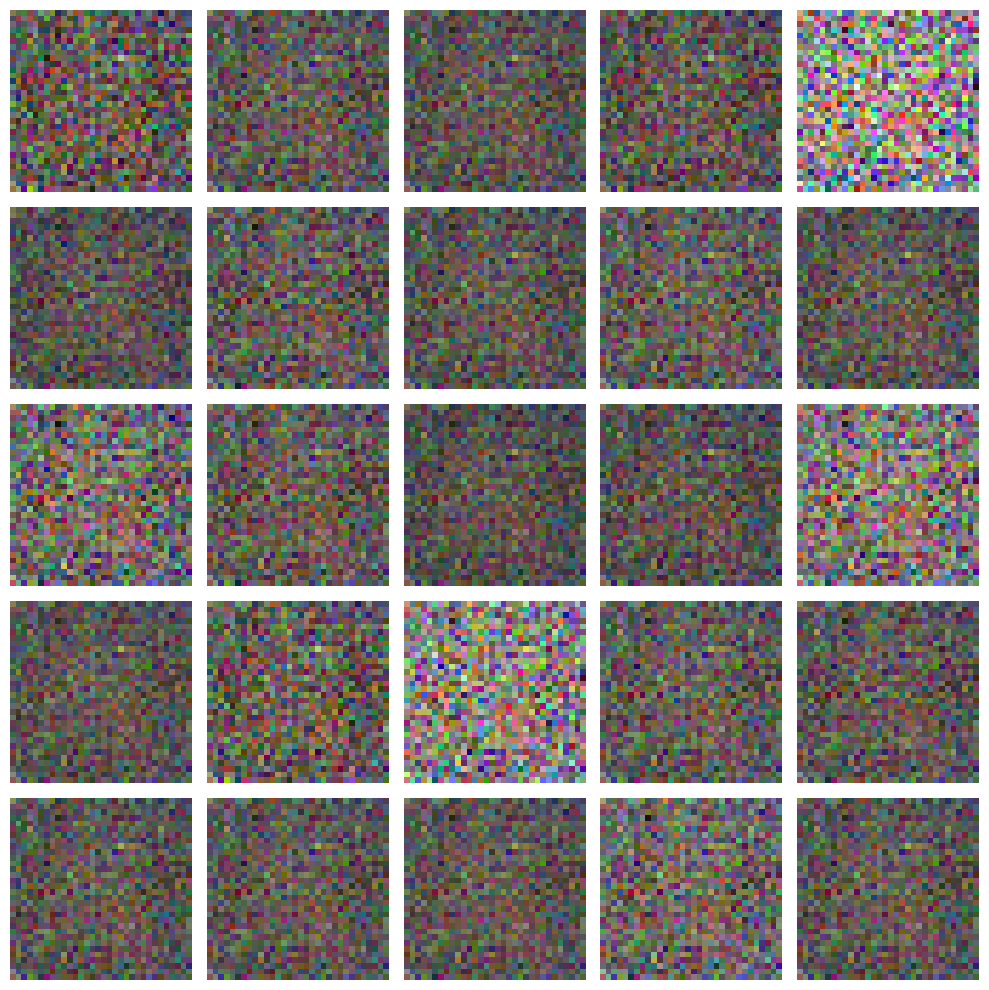

In [27]:
import matplotlib.pyplot as plt

# Generate random noise
num_images_to_generate = 150000
latent_dim = 200
noise = generate_noise(num_images_to_generate, latent_dim)

# Generate fake images
fake_images = generator.predict(noise)

# Filter images based on discriminator predictions
predictions = discriminator.predict(fake_images)
predictions = predictions.squeeze()  # Remove singleton dimensions
threshold = 0.5  # Adjust the threshold as needed
filtered_images = fake_images[predictions > threshold]

# Visualize the filtered images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(filtered_images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

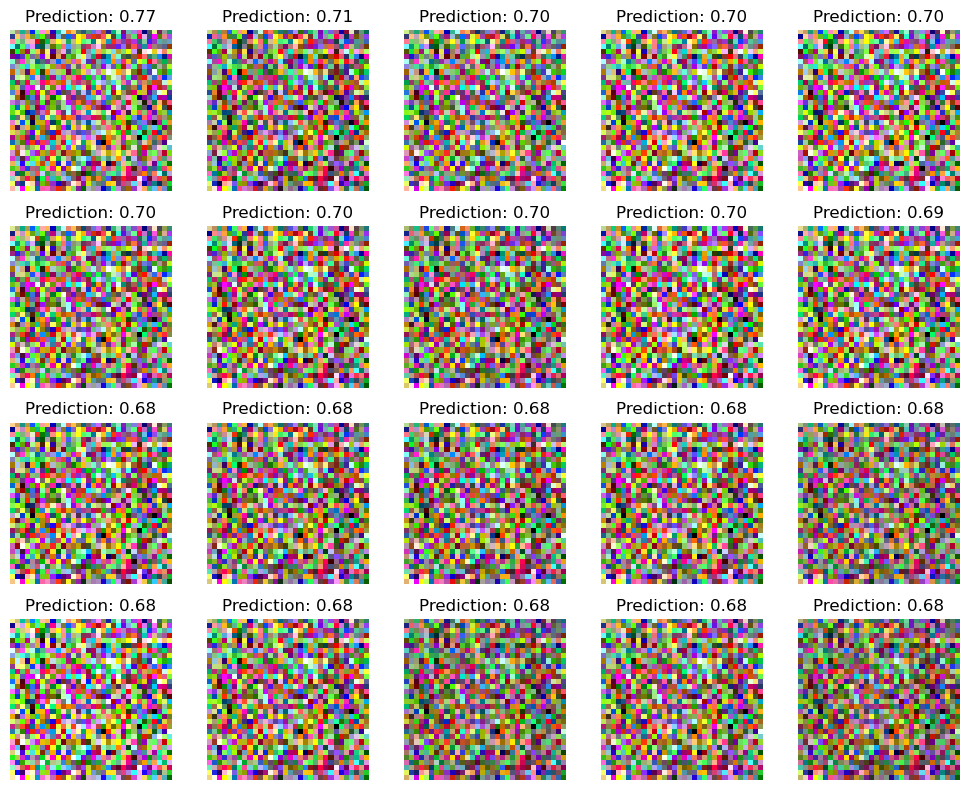

In [28]:
# Sort predictions in descending order and get the indices of top 20
top_indices = predictions.argsort()[-20:][::-1]

# Select the top 20 images
filtered_images = fake_images[top_indices]
filtered_predictions = predictions[top_indices]

# Visualize the filtered images and their predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(filtered_images[i])
    ax.set_title(f"Prediction: {filtered_predictions[i]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

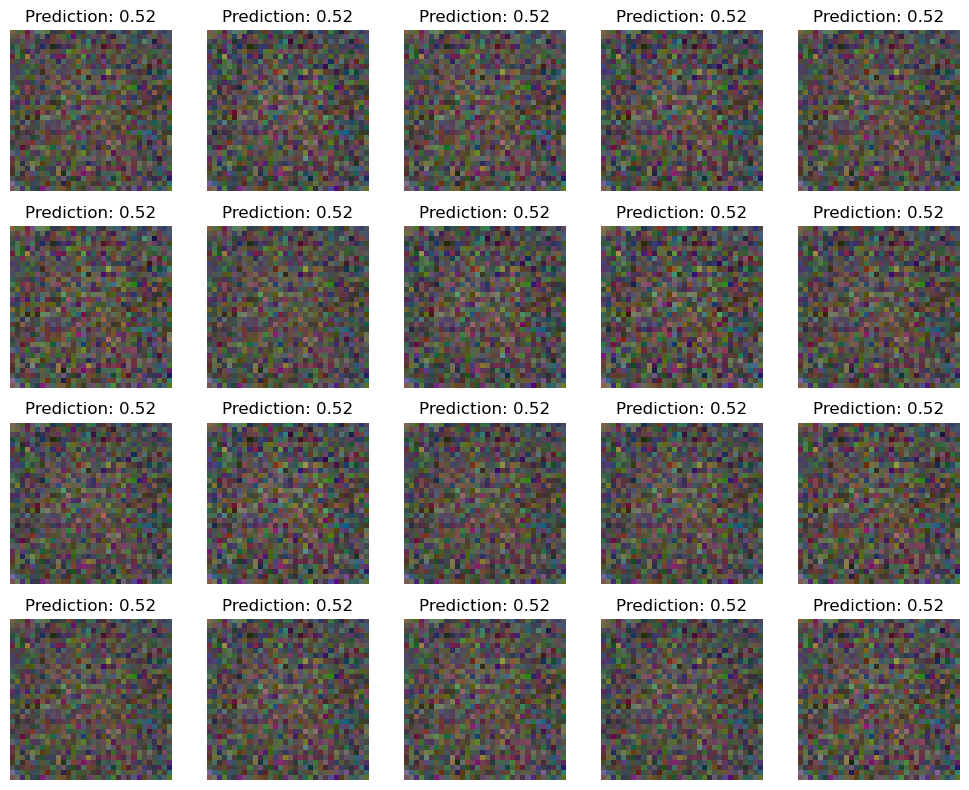

In [29]:
# Sort predictions in ascending order and get the indices of bottom 20
bottom_indices = predictions.argsort()[:20]

# Select the bottom 20 images and predictions
filtered_bottom_images = fake_images[bottom_indices]
filtered_bottom_predictions = predictions[bottom_indices]

# Visualize the filtered bottom images and their predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(filtered_bottom_images[i])
    ax.set_title(f"Prediction: {filtered_bottom_predictions[i]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()